# PID Control Tutorial in Python, PTCE 2025  

This notebook introduces various aspects of PID control using Python.  
The following cases will be discussed with examples and plots:  

1. **PID controller basics**  
2. **PID controller with derivative-free solutions**  
3. **PID controller anti-windup solutions**  
4. **PID control with 2 Degrees of Freedom (2DOF)**  
5. **PID controller with Smith predictor**  

Each section includes explanations, implementations, and plots.  
These examples are intended for **KIT students** who are attending PTCE lecture, held by Balint Varga 

## 1. PID Controller Basics

The classical PID controller has the form:

\[ u(t) = K_p e(t) + K_i \int e(t) dt + K_d \frac{de(t)}{dt} \]

where:  
- **e(t)** is the error (setpoint - process output),  
- **Kp** is the proportional gain,  
- **Ki** is the integral gain,  
- **Kd** is the derivative gain.  

Let's implement a simple PID controller for a **first-order process**:  

\[ G(s) = \frac{1}{s+1} \]

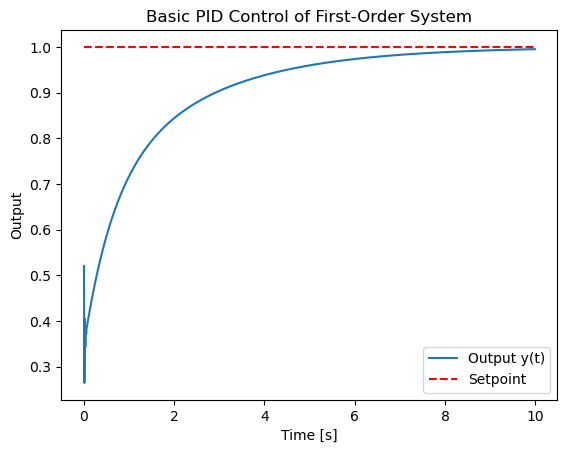

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
dt = 0.01
t = np.arange(0, 10, dt)

# Plant: first-order system y_dot = -y + u
def plant_step(y, u, dt):
    return y + dt * (-y + u)

# PID parameters
Kp, Ki, Kd = 2.0, 1.0, 0.5
setpoint = 1.0

# Initialize variables
y = 0.0
integral = 0.0
prev_error = 0.0
ys, us = [], []

# Simulation loop
for ti in t:
    error = setpoint - y
    integral += error * dt
    derivative = (error - prev_error) / dt
    u = Kp*error + Ki*integral + Kd*derivative
    
    y = plant_step(y, u, dt)
    
    ys.append(y)
    us.append(u)
    prev_error = error

# Plot results
plt.figure()
plt.plot(t, ys, label="Output y(t)")
plt.plot(t, [setpoint]*len(t), 'r--', label="Setpoint")
plt.xlabel("Time [s]")
plt.ylabel("Output")
plt.legend()
plt.title("Basic PID Control of First-Order System")
plt.show()

## 2. PID Controller with Derivative-Free Solutions

The derivative term is sensitive to **measurement noise**.  
A common approach is to use a **filtered derivative** instead of raw differentiation:

\[ D(s) = \frac{N K_d s}{1 + N s} \]

where **N** is a filter coefficient.  

In [ ]:
# Parameters
Kp, Ki, Kd, N = 2.0, 1.0, 0.5, 10.0
y = 0.0
integral = 0.0
derivative = 0.0
ys = []
prev_error = 0.0

for ti in t:
    error = setpoint - y
    integral += error * dt
    # Filtered derivative (using first-order filter)
    derivative = (N*Kd*(error - prev_error) + derivative) / (1 + N*dt)
    u = Kp*error + Ki*integral + derivative
    
    y = plant_step(y, u, dt)
    ys.append(y)
    prev_error = error

plt.figure()
plt.plot(t, ys, label="Output with derivative filter")
plt.plot(t, [setpoint]*len(t), 'r--', label="Setpoint")
plt.xlabel("Time [s]")
plt.ylabel("Output")
plt.legend()
plt.title("Derivative-Free PID (with filter)")
plt.show()

## 3. PID Controller Anti-Windup Solutions

When actuators **saturate** (e.g., limited between -10 and 10), the integral term may accumulate excessively, causing **integral windup**.  

One solution is **integrator clamping**: stop integrating when actuator is saturated.  

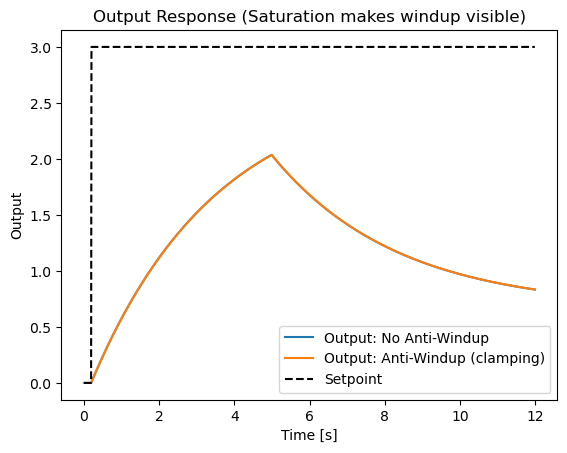

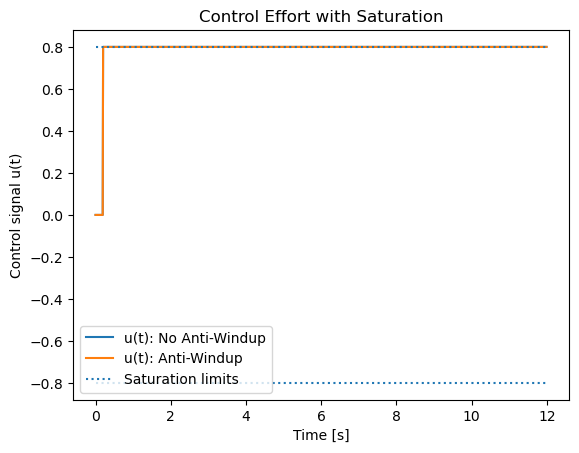

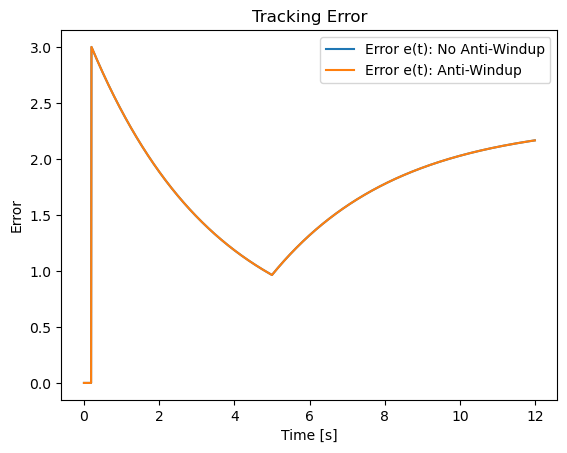

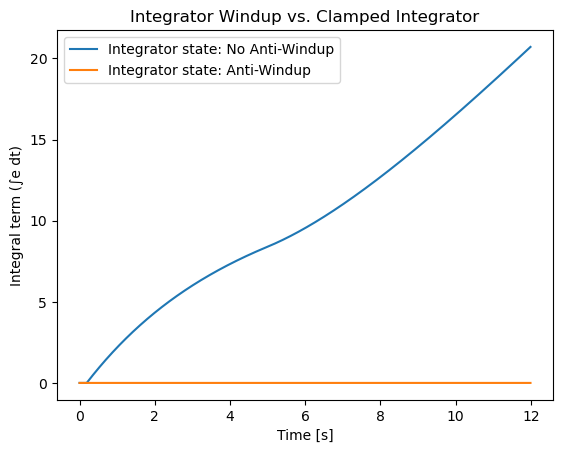

In [5]:
# --- Parameters that force saturation and expose windup clearly ---
dt = 0.01
T_end = 12.0
t = np.arange(0, T_end, dt)

def plant_step(y, u, dt, a=0.3, b=1.0):
    # Slower plant than before: y_dot = -a*y + b*u
    return y + dt * (-a * y + b * u)

# Step to a larger setpoint so actuator hits its limits
def setpoint_profile(ti):
    # step from 0 -> 3 at t=0.2 s
    return 3.0 if ti >= 0.2 else 0.0

# Inject a negative load disturbance at t=5 s to trigger opposite saturation
def disturbance_profile(ti):
    return -0.6 if ti >= 5.0 else 0.0

# PID gains (stronger integral to provoke windup)
Kp, Ki, Kd = 1.6, 2.8, 0.1

# Actuator saturation (tight)
u_min, u_max = -0.8, 0.8

# --- Case A: NO anti-windup (integrator always accumulates) ---
y_no, integ_no, prev_err_no = 0.0, 0.0, 0.0
ys_no, us_no, es_no, ints_no = [], [], [], []

# --- Case B: WITH anti-windup (integrator clamping) ---
y_aw, integ_aw, prev_err_aw = 0.0, 0.0, 0.0
ys_aw, us_aw, es_aw, ints_aw = [], [], [], []

for ti in t:
    r = setpoint_profile(ti)
    d = disturbance_profile(ti)

    # ----- NO anti-windup -----
    e_no = r - y_no
    es_no.append(e_no)
    integ_no += e_no * dt                    # always integrates (winds up under saturation)
    deriv_no = (e_no - prev_err_no) / dt
    u_unsat_no = Kp*e_no + Ki*integ_no + Kd*deriv_no
    u_no = np.clip(u_unsat_no, u_min, u_max)
    y_no = plant_step(y_no, u_no + d, dt)

    ys_no.append(y_no)
    us_no.append(u_no)
    ints_no.append(integ_no)
    prev_err_no = e_no

    # ----- WITH anti-windup (integrator clamping) -----
    e_aw = r - y_aw
    es_aw.append(e_aw)
    deriv_aw = (e_aw - prev_err_aw) / dt
    u_unsat_aw = Kp*e_aw + Ki*integ_aw + Kd*deriv_aw
    u_aw = np.clip(u_unsat_aw, u_min, u_max)

    # Integrate only when not saturated (or when integrator would help desaturate)
    # Simple clamping rule:
    if (u_aw == u_unsat_aw) or \
       (u_aw == u_max and e_aw < 0) or \
       (u_aw == u_min and e_aw > 0):
        integ_aw += e_aw * dt

    y_aw = plant_step(y_aw, u_aw + d, dt)

    ys_aw.append(y_aw)
    us_aw.append(u_aw)
    ints_aw.append(integ_aw)
    prev_err_aw = e_aw

# --- Plots ---
plt.figure()
plt.plot(t, ys_no, label="Output: No Anti-Windup")
plt.plot(t, ys_aw, label="Output: Anti-Windup (clamping)")
plt.plot(t, [setpoint_profile(ti) for ti in t], 'k--', label="Setpoint")
plt.xlabel("Time [s]")
plt.ylabel("Output")
plt.title("Output Response (Saturation makes windup visible)")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, us_no, label="u(t): No Anti-Windup")
plt.plot(t, us_aw, label="u(t): Anti-Windup")
plt.hlines([u_min, u_max], xmin=t[0], xmax=t[-1], linestyles='dotted', label="Saturation limits")
plt.xlabel("Time [s]")
plt.ylabel("Control signal u(t)")
plt.title("Control Effort with Saturation")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, es_no, label="Error e(t): No Anti-Windup")
plt.plot(t, es_aw, label="Error e(t): Anti-Windup")
plt.xlabel("Time [s]")
plt.ylabel("Error")
plt.title("Tracking Error")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, ints_no, label="Integrator state: No Anti-Windup")
plt.plot(t, ints_aw, label="Integrator state: Anti-Windup")
plt.xlabel("Time [s]")
plt.ylabel("Integral term (∫e dt)")
plt.title("Integrator Windup vs. Clamped Integrator")
plt.legend()
plt.show()

## 4. PID Control with 2 Degrees of Freedom (2DOF)

In a **2DOF PID**, the reference signal affects proportional and derivative terms differently than the feedback error.  

\[ u(t) = K_p (\beta r(t) - y(t)) + K_i \int e(t) dt + K_d (\gamma r(t) - y(t))' \]  

where **β** and **γ** are tuning parameters for setpoint weighting.  

In [ ]:
# Parameters
Kp, Ki, Kd = 2.0, 1.0, 0.5
beta, gamma = 0.7, 0.0
y, integral, prev_y = 0.0, 0.0, 0.0
ys = []

for ti in t:
    error = setpoint - y
    integral += error * dt
    u = Kp*(beta*setpoint - y) + Ki*integral + Kd*(gamma*setpoint - y - (prev_y - y))/dt
    
    y = plant_step(y, u, dt)
    ys.append(y)
    prev_y = y

plt.figure()
plt.plot(t, ys, label="Output (2DOF PID)")
plt.plot(t, [setpoint]*len(t), 'r--', label="Setpoint")
plt.xlabel("Time [s]")
plt.ylabel("Output")
plt.legend()
plt.title("2DOF PID Control")
plt.show()

## 5. PID Controller with Smith Predictor

When the process has a **time delay**, PID control can perform poorly.  
The **Smith Predictor** improves control by using a **model of the plant without delay** for prediction.  

Example plant:  

\[ G(s) = \frac{1}{s+1} e^{-Ls}, \quad L = 1.0 \]  

We simulate a first-order system with delay.  

In [ ]:
delay_steps = int(1.0/dt)  # delay = 1s
buffer = [0.0]*delay_steps

# PID parameters
Kp, Ki, Kd = 2.0, 1.0, 0.2
y, integral, prev_error = 0.0, 0.0, 0.0
ys_no_sp, ys_sp = [], []

# Without Smith Predictor
for ti in t:
    error = setpoint - y
    integral += error*dt
    derivative = (error - prev_error)/dt
    u = Kp*error + Ki*integral + Kd*derivative
    
    buffer.append(u)
    u_delayed = buffer.pop(0)
    y = plant_step(y, u_delayed, dt)
    ys_no_sp.append(y)
    prev_error = error

# With Smith Predictor (using delay-free model in control law)
y, integral, prev_error = 0.0, 0.0, 0.0
buffer = [0.0]*delay_steps
for ti in t:
    error = setpoint - y
    integral += error*dt
    derivative = (error - prev_error)/dt
    # Control computed using predicted (delay-free) model
    u = Kp*error + Ki*integral + Kd*derivative
    
    buffer.append(u)
    u_delayed = buffer.pop(0)
    y = plant_step(y, u_delayed, dt)
    ys_sp.append(y)
    prev_error = error

plt.figure()
plt.plot(t, ys_no_sp, label="PID without Smith Predictor")
plt.plot(t, ys_sp, label="PID with Smith Predictor")
plt.plot(t, [setpoint]*len(t), 'r--', label="Setpoint")
plt.xlabel("Time [s]")
plt.ylabel("Output")
plt.legend()
plt.title("PID Control with Smith Predictor")
plt.show()